In [17]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
#import psycopg2
#from src.scraper import *
from src.process_words import *
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import datetime as dt
import pickle
from itertools import combinations

import networkx as nx
import nxpd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [ ]:
#conn = psycopg2.connect(dbname='food_db')
#df = pd.read_sql('SELECT * FROM recipes', con=conn)
#df['food_stems'] = [clean_one_doc(recipe) for recipe in df['foods']]

In [2]:
df = pd.read_pickle('data/featured_recipes.pkl')
df.head()

,id,post_date,title,foods,food_stems
0,27,2018-02-09,Long Life Noodles with Shrimp and Greens,"teaspoon sesame oil, for drizzling stalk green...","[sesam, oil, stalk, onion, carrot, stalk, onio..."
1,28,2018-02-09,Ginger-Onion Whole Steamed Fish,"stalks green onions, cut into 3-inch segments,...","[stalk, onion, segment, wine, marsala, wine, o..."
2,29,2018-02-09,Smacked Cucumber,"teaspoon sugar cloves garlic, crushed tablespo...","[sugar, clove, flake, chili, cucumb, cucumb, v..."
3,30,2018-02-08,Neck Bones and Lima Beans,"salt and pepper, to taste tablespoons canola o...","[oil, sage, lima, bean, water, nutmeg, onion, ..."
4,31,2018-02-07,Angel Wings (Faworki),pinch sea salt confectioner’s sugar for servin...,"[sea, confection, cream, egg, yolk, powder, co..."


In [ ]:
#top_words, label_list = process_words.make_top_words(df, 'foods', 20)

In [12]:
y, full_X = vectorize_all(df, 'foods', split_years=False)
full_X, full_features = full_X
total = np.sum(full_X, axis=0) #total -- the total tfidf sum of each ingredient
total = np.asarray(total)[0]

In [19]:
recipes = df['food_stems']

In [22]:
def make_graph(full_features, n, plot=False):
    top_n = np.array([np.array(full_features)[i] for i in np.argsort(total)[-1:-n-1:-1]])
    edges = list(combinations(top_n, 2))
    weighted_edges = {edge: 0 for edge in edges}
    for recipe in recipes:
        common = top_n[np.in1d(top_n, recipe)]
        common_pairs = list(combinations(common, 2))
        for pair in common_pairs:
            weighted_edges[pair] += 1
    weighted_edges = [(k[0], k[1], v) for k, v in weighted_edges.items()]
    
    G = nx.Graph()
    G.add_weighted_edges_from(weighted_edges)
    
    if plot:
        fig, ax = plt.subplots(figsize=(12,12))
        node_and_degree=G.degree()
        weights = np.array([G.get_edge_data(u,v)['weight'] for u,v in G.edges()])
        # Draw graph
        pos = nx.spring_layout(G, k=6/np.sqrt(G.order()))
        _ = nx.draw_networkx_edges(G, pos=pos, ax=ax, alpha=0.2, width=weights**(1/3), 
                                   edge_color=plt.cm.Blues(weights*5))
        _ = nx.draw_networkx_nodes(G, #node_size=[v**2 for v in dict(node_and_degree).values()],
                                   pos=pos, ax=ax, node_color='lightblue')
        _ = nx.draw_networkx_labels(G, pos=pos, font_family="serif", font_weight="ultralight")
    return G

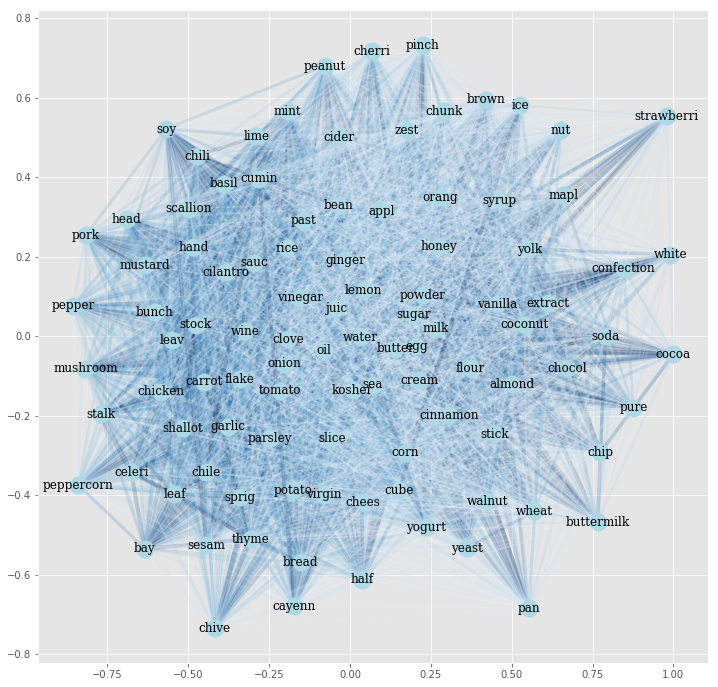

In [25]:
G = make_graph(full_features, 100, plot=True)

### Make Clusters

In [ ]:
k = process_words.get_best_k(full_X)
k

In [ ]:
full_centroids, full_labels = process_words.make_clusters(
    full_X, full_features, k)

In [ ]:
full_centroids

In [ ]:
full_cluster_df, full_labels = process_words.make_one_cluster_df(full_X, full_features, k, 'all')

In [ ]:
full_cluster_df.head(20)

In [ ]:
total = np.sum(full_X, axis=0)
total = np.asarray(total)[0]
top200 = np.array([np.array(full_features)[i] for i in np.argsort(total)[-1:-200-1:-1]])
top50 = np.array([np.array(full_features)[i] for i in np.argsort(total)[-1:-50-1:-1]])
top10 = np.array([np.array(full_features)[i] for i in np.argsort(total)[-1:-10-1:-1]])
print ("top 200 by total tf-idf")
print (top200)

In [ ]:
### Future work: Create a function to make graphs of a given list of ingredients